# Lab. 9: Design of Experiments

## Introduction

#### <u>The goal of this lab is observe the effect of the DoE in the Bayesian optimization and Bio-inspired approaches.</u>

You'll have to implement four sampling methods:

Random sampling
The Halton sequence
The full factorial sampling
The Latin Hypercube sampling

- *Random sampling*
- *The Halton sequence*
- *The full factorial sampling*
- *The Latin Hypercude sampling*
---

Getting started: The following cells contain the implementation of the methods that we will use throughout this lab, together with utilities.

**NOTE**:

When studying the effect of the parameters is extremely important to vary just one parameter at a time. Therefore, it is suggested to study one parameter by fixing all the others, and then moving to the next.

Moreover, when comparing different algorithms, is very important to run each of them several times (e.g., 30) by using different initial random seeds.

In [3]:
# @title Imports
# %%capture

!pip install benchmark_functions
!pip install inspyred

import random
import functools
from inspyred import ec
import numpy as np
from typing import List
from dataclasses import dataclass, field
import benchmark_functions as bf
from copy import deepcopy
import matplotlib.pyplot as plt
from math import ceil, floor
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
from inspyred import ec
from inspyred.ec import EvolutionaryComputation
from inspyred.ec import selectors, replacers, terminators
from pylab import *
from random import Random
from scipy.stats import uniform as uniform_fun
from scipy.stats import norm as norm_fun

In [83]:
#@title Helper functions

GLOBAL = 'Global'
INDIVIDUAL = 'Individual'
CORRELATED = 'Correlated'
STAR = 'star'
RING = 'ring'

class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []
        self.__name__ = f'OptFun({wf.__class__})'

    def __call__(self, candidates, *args, **kwargs):
        """
        Evaluate the objective function for a list of candidates.
        """
        y = []
        for x0 in candidates:
            self.history.append(deepcopy(x0))
            y.append(self.f(x0))
        return y

    def minima(self):
        return self.f.minima()

    def bounder(self):
        def fcn(candidate, *args):
            bounds = self.f.suggested_bounds()

            for i, (m, M) in enumerate(zip(*bounds)):
                if candidate[i] < m:
                    candidate[i] = m
                if candidate[i] > M:
                    candidate[i] = M
            return candidate
        return fcn

    def bounds(self):
        """
        Return the bounds of the objective function.
        """
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.manager.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata, ydata, "or-", markersize=3, linewidth=1)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot_population_evolution(self, populations, generation_step=2, single=False, grid=False, args=[]):
        plt.clf()
        resolution = 50
        fig, ax = plt.subplots(2, 3) if not single else plt.subplots(1,1)
        if single:
            ax = [ax]
            fig.set_figwidth(5)
            fig.set_figheight(5)
        else:
            ax = ax.flatten()
            fig.set_figwidth(10)
            fig.set_figheight(7)

        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])


        for i in range(min(len(populations),6)):
            if i*generation_step<len(populations):
                ax[i].contour(x,y,Z,15,linewidths=0.5,colors='k')
                ax[i].contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
                ax[i].set_xlabel('x')
                ax[i].set_ylabel('y')
                ax[i].title.set_text("Generation " + str(i*generation_step))

                # scatter plot of the population
                current_pop = populations[i*generation_step]
                xdata = [x[0] for x in current_pop]
                ydata = [x[1] for x in current_pop]
                ax[i].scatter(xdata, ydata, color="r", zorder=2, label="population")

                if single:
                    break

        # Add the grid
        if single and grid:
            grid_spacing = (args["pop_init_range"][1] - args["pop_init_range"][0])/args["pop_size"]
            intervals = float(grid_spacing)
            ax[0].set_yticks(np.linspace(args["pop_init_range"][0], args["pop_init_range"][1], len(populations[0])+1), minor=False)
            ax[0].set_xticks(np.linspace(args["pop_init_range"][0], args["pop_init_range"][1], len(populations[0])+1), minor=False)
            ax[0].grid(which='both', axis='both', linestyle='-', color='k', linewidth=1.4)

        handles, labels = ax[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        plt.tight_layout()
        plt.show()

    def plot(self):
        plt.clf()
        values = [self.f(v) for v in self.history]
        min = func.minima()[0].score
        plt.plot(values)
        plt.axhline(min, color="r", label="optimum")
        plt.legend()
        plt.show()

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds

    def current_calls(self):
        return len(self.history)

def choice_without_replacement(rng, n, size) :
    result = set()
    while len(result) < size :
        result.add(rng.randint(0, n))
    return result

class NumpyRandomWrapper(RandomState):
    def __init__(self, seed=None):
        super(NumpyRandomWrapper, self).__init__(seed)

    def sample(self, population, k):
        if isinstance(population, int) :
            population = range(population)

        return asarray([population[i] for i in
                        choice_without_replacement(self, len(population), k)])
        #return #self.choice(population, k, replace=False)

    def random(self):
        return self.random_sample()

    def gauss(self, mu, sigma):
        return self.normal(mu, sigma)

def initial_pop_observer(population, num_generations, num_evaluations,
                         args):
    if num_generations == 0 :
        args["initial_pop_storage"]["individuals"] = asarray([guy.candidate
                                                 for guy in population])
        args["initial_pop_storage"]["fitnesses"] = asarray([guy.fitness
                                          for guy in population])

def generator(case, random, args):
    if case == "random":
        args["sequence"] = random_generator(random, args)
    if case == "LHS":
        args["sequence"] = lhs_generator(random, args)
    if case == "Halton":
        args["sequence"] = Halton_generator(random, args)
    if case == "FF":
        args["sequence"] = ff_generator(random, args)
    if case == "random_2d":
        args["sequence"] = random_generator_2d(random, args)
    if case == "LHS_2d":
        args["sequence"] = lhs_generator_2d(random, args)
    if case == "Halton_2d":
        args["sequence"] = Halton_generator_2d(random, args)
    if case == "FF_2d":
        args["sequence"] = ff_generator_2d(random, args)
    args["index"] = 0
    return fake_generator

def fake_generator(random, args):
    index = args["index"]
    args["index"] += 1

    return args["sequence"][index]

def generator_wrapper(func):
        @functools.wraps(func)
        def _generator(random, args):
            return np.asarray(func(random, args))
        return _generator


# helper function used to store the various populations at each generation
def my_archiver(random, population, archive, args):
    archive.append(population)
    return archive

def run_ga(random, generator_type, func,
           maximize=False, **kwargs) :
    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = ec.EvolutionaryComputation(random)
    algorithm.terminator = ec.terminators.generation_termination
    algorithm.replacer = ec.replacers.generational_replacement
    algorithm.variator = [ec.variators.uniform_crossover,ec.variators.gaussian_mutation]
    algorithm.selector = ec.selectors.tournament_selection
    algorithm.archiver = my_archiver
    algorithm.observer = initial_pop_observer

    num_vars = kwargs["num_vars"]
    kwargs["num_selected"]=kwargs["pop_size"]
    kwargs["bounder"]=func.bounder()
    kwargs["generator"]= generator(generator_type, random, kwargs)

    final_pop = algorithm.evolve(evaluator=func,
                          maximize=False,
                          initial_pop_storage=initial_pop_storage,
                          **kwargs)

    all_populations = algorithm.archive
    for i in range(len(all_populations)):
        all_populations[i] = [elem.candidate for elem in all_populations[i]]

    #best_guy = final_pop[0].candidate
    #best_fitness = final_pop[0].fitness
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate for guy in final_pop])

    sort_indexes = sorted(range(len(final_pop_fitnesses)), key=final_pop_fitnesses.__getitem__)
    final_pop_fitnesses = final_pop_fitnesses[sort_indexes]
    final_pop_candidates = final_pop_candidates[sort_indexes]

    best_guy = final_pop_candidates[0]
    best_fitness = final_pop_fitnesses[0]

    return best_guy, best_fitness, final_pop, all_populations


## Exercises

### Exercise 1/3: Implement different sampling methods

In [5]:
def random_generator(random, args):
    num_vars = args["num_vars"]
    pop_size = args["pop_size"]
    pop_init_range = args["pop_init_range"]

    population = []
    for _ in range(pop_size):
        individual = [random.uniform(pop_init_range[0], pop_init_range[1]) for _ in range(num_vars)]
        population.append(individual)
    
    return np.asarray(population)


def random_generator_2d(random, args):
    seq1 = random_generator(random, args)
    seq2 = random_generator(random, args)

    return np.asarray(list(zip(seq1, seq2)))

In [6]:
# generates a single Halton sequence value for a given index and base 
def halton_seq(n, dim):
    def halton_single_seq(index, base):
        result = 0
        f = 1 / base
        i = index
        while i > 0:
            result += f * (i % base)
            i = np.floor(i / base)
            f /= base
        return result

    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]  # First 25 prime numbers
    seq = np.zeros((n, dim))
    for i in range(dim):
        base = primes[i]
        for j in range(n):
            seq[j, i] = halton_single_seq(j + 1, base)
    return seq

def Halton_generator(random, args):
    num_vars = args["num_vars"]
    pop_size = args["pop_size"]
    pop_init_range = args["pop_init_range"]

    halton_seq_array = halton_seq(pop_size, num_vars)
    population = pop_init_range[0] + halton_seq_array * (pop_init_range[1] - pop_init_range[0])
    
    return population
    

def Halton_generator_2d(random, args):
    seq1 = Halton_generator(random, args)
    seq2 = Halton_generator(random, args)

    return np.asarray(list(zip(seq1, seq2)))

In [7]:
def lhs_generator(random, args, j=0):
    num_vars = args["num_vars"]
    pop_size = args["pop_size"]
    pop_init_range = args["pop_init_range"]

    # Generate Latin Hypercube Sampling
    samples = np.zeros((pop_size, num_vars))
    for i in range(num_vars):
        segment = (pop_init_range[1] - pop_init_range[0]) / pop_size
        samples[:, i] = pop_init_range[0] + (np.arange(pop_size) + random.uniform(0, 1)) * segment

        # Shuffle each column
        random.shuffle(samples[:, i])

    return samples

def lhs_generator_2d(random, args):
    seq1 = lhs_generator(random, args, 0)
    seq2 = lhs_generator(random, args, 1)

    random.shuffle(seq2)

    return np.asarray(list(zip(seq1, seq2)))

In [8]:
import itertools
import itertools
import numpy as np

def ff_generator(random, args):
    # Extract parameters
    num_vars = args["num_vars"]
    pop_size = args["pop_size"]
    pop_init_range = args["pop_init_range"]

    # Generate all possible combinations of values for the variables
    variable_values = [np.linspace(pop_init_range[0], pop_init_range[1], num=pop_size) for _ in range(num_vars)]
    variable_combinations = list(itertools.product(*variable_values))

    return np.asarray(variable_combinations)



def full_factorial_generator_2d(args):
    seq1 = full_factorial_generator(args)
    seq2 = full_factorial_generator(args)
    
    return np.asarray(list(itertools.product(seq1, seq2)))


In [9]:
def plot_convergence_curve(final_pop_fitnesses):
    plt.figure()
    plt.plot(final_pop_fitnesses)
    plt.title("Convergence Curve")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.show()

### Exercise 2/3: Visualize the implemented methods

### Exercise 3/3: Genetic algorithm - testing different initial sampling methods

******************************
random
Best Solution: [-0.99595179  0.01307499]
Best Fitness: 1.0290518527986023


<Figure size 640x480 with 0 Axes>

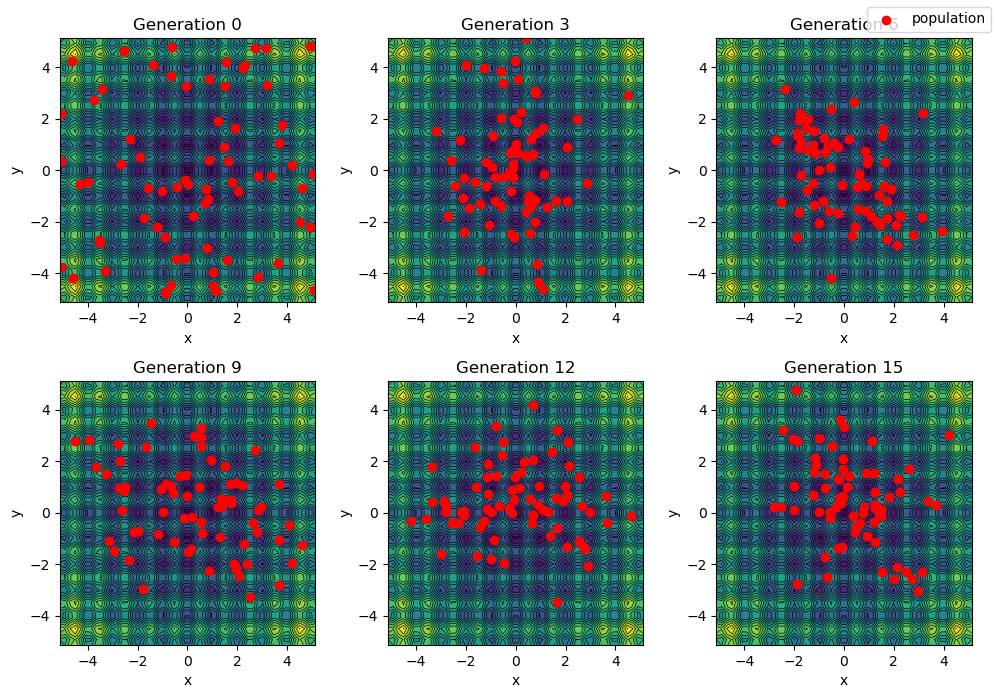

******************************
LHS
Best Solution: [0.02895927 0.04910967]
Best Fitness: 0.6406318804761213


<Figure size 640x480 with 0 Axes>

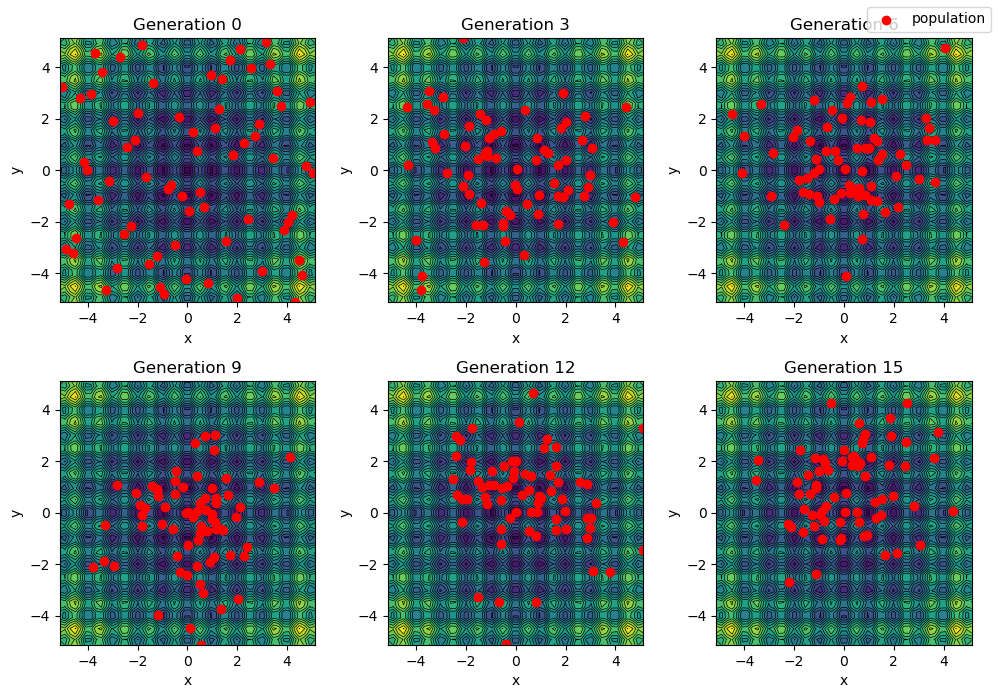

******************************
Halton
Best Solution: [0.04677259 0.02777357]
Best Fitness: 0.5835662977641007


<Figure size 640x480 with 0 Axes>

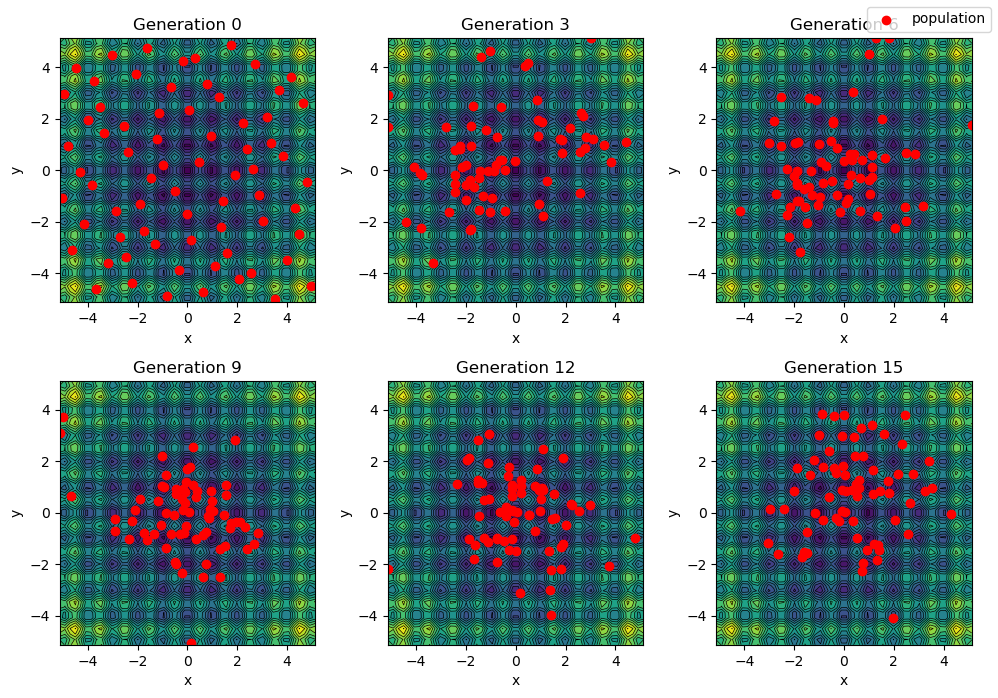

******************************
FF
Best Solution: [ 0.00124127 -0.0369464 ]
Best Fitness: 0.26991022354785343


<Figure size 640x480 with 0 Axes>

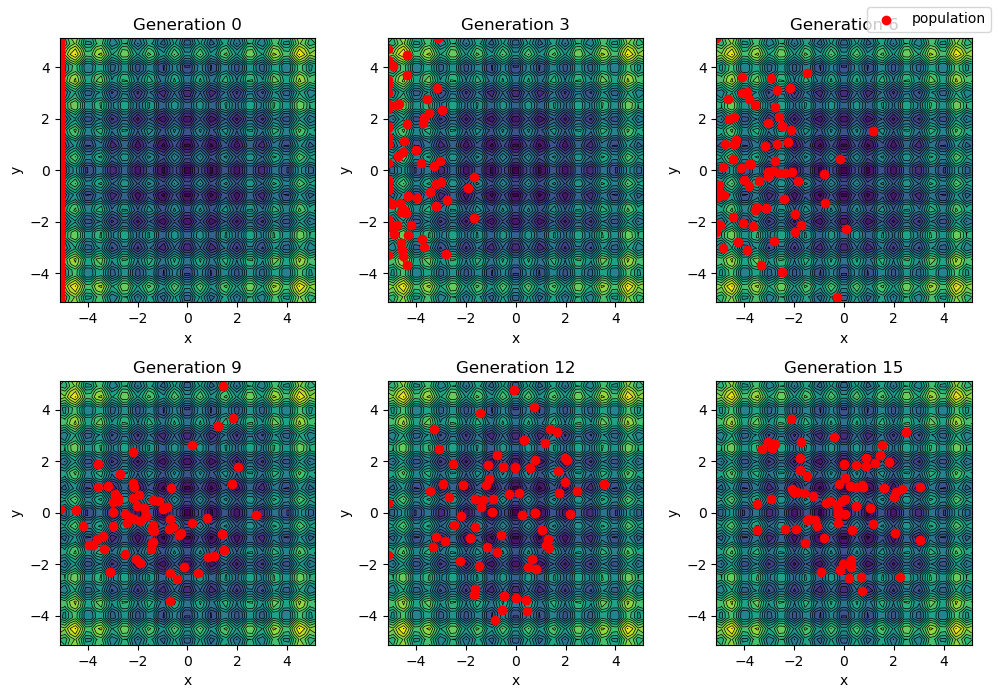

In [78]:
import random
func = OptFun(bf.Rastrigin(2))

args = {}
args["num_vars"] = 2 # Number of dimensions of the search space
args["gaussian_stdev"] = 1.0 # Standard deviation of the Gaussian mutations
args["tournament_size"] = 2
args["num_elites"] = 1 # number of elite individuals to maintain in each gen
args["pop_size"] = 70 # population size
args["pop_init_range"] = func.bounds()[0] # Range for the initial population
args["max_generations"] = 20 # Number of generations of the GA
args["crossover_rate"] = 0.03
args["mutation_rate"] = 0.9
args["initial_pop_size"] = args["pop_size"]

generator_types = ["random", "LHS", "Halton", "FF"]
generator_types_2d = ["random_2d", "LHS_2d", "Halton_2d", "FF_2d"]

x = 9

# random.seed(100)
# best_guy, best_fitness, final_pop, all_populations = run_ga(random, "random", func, maximize=False, **args)
# func.plot_population_evolution(populations=all_populations, args=args)

best_fitnesses = []

for generator_type in generator_types:
    random.seed(x+1)

    print("*"*30)
    print(generator_type)

    # Run the genetic algorithm
    best_guy, best_fitness, final_pop, all_populations = run_ga(random, generator_type, func, maximize=False, **args)
    best_fitnesses.append(best_fitness)
    print("Best Solution:", best_guy)
    print("Best Fitness:", best_fitness)
    # Plot the population evolution
    func.plot_population_evolution(populations=all_populations, args=args)

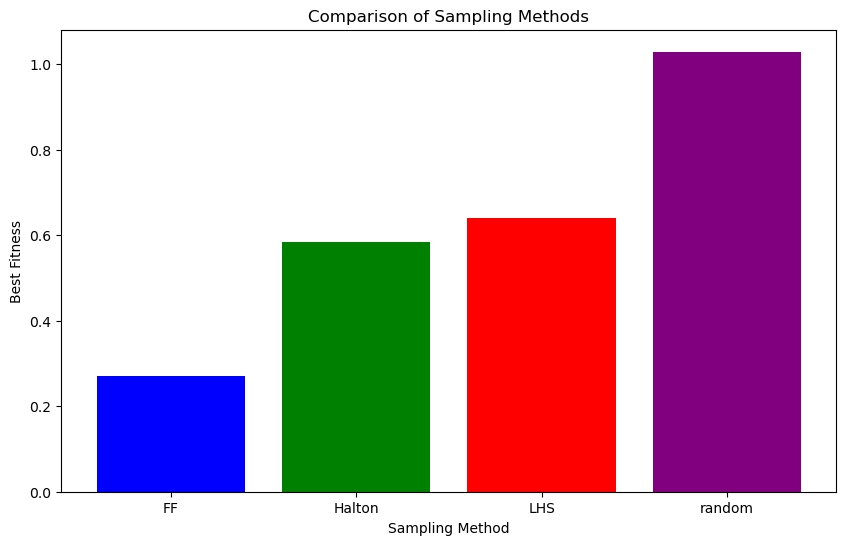

In [79]:
# Plot the comparison
# Sort the sampling methods and corresponding fitness values by fitness value
sorted_data = sorted(zip(generator_types, best_fitnesses), key=lambda x: x[1])

# Extract sorted sampling methods and fitness values
sorted_generator_types, sorted_best_fitnesses = zip(*sorted_data)

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.bar(sorted_generator_types, sorted_best_fitnesses, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Sampling Method')
plt.ylabel('Best Fitness')
plt.title('Comparison of Sampling Methods')
plt.show()

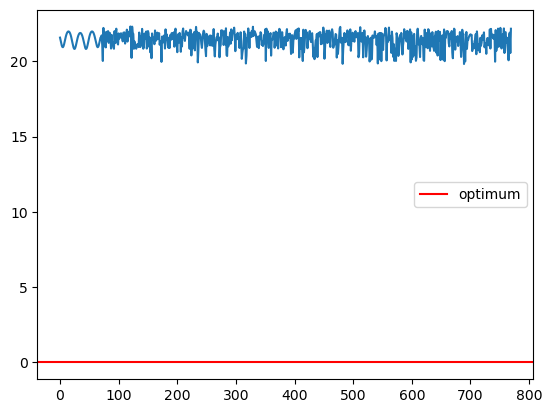

In [12]:
func.plot()

## Questions

Compare the GA studied in the previous lessons with its enhanced version with different DOE techniques.

#### 1. **How do the performances increases? Are the algorithms faster to converge, or can they find better solutions?**

#### 2. **Is there an approach better than the others in terms of performance?**

#### 3. **How much do the DOEs affect the search cost?**